In [1]:
import numpy as np

In [2]:
def make_p_matrix(matrix):
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:]

def fix_dangling_node(H):
    # Finds which rows have all elements zeros
    # d is a column vector that identifies dangling nodes
    d = ~(H.any(axis=1))
    # w is a uniform row vector
    w = np.full(H.shape[1], 1/H.shape[1])
    S = H + d*w
    return S

def form_google_matrix(S, v=None, alpha=0.85):
    if v is None:
         v = np.full(S.shape[1], 1/S.shape[1])
    one_vector = np.ones(S.shape[0])
    return alpha*S + (1-alpha)*one_vector*v


def power_method2(H, v=None, alpha=0.85):
    if v is None:
         v = np.full(H.shape[1], 1/H.shape[1])
    d = ~(H.any(axis=1))
    w = np.full(H.shape[1], 1/H.shape[1])
    # start with pi = v
    pi = np.zeros(H.shape[0])
    pi_new = v
    cnt = 0
    print(H.shape)
    while not np.allclose(pi_new, pi):
        pi = pi_new
        pi_new = alpha * pi * H + alpha * (pi*d) * w + (1-alpha) * v
        cnt += 1
    #print("Power method2 went through {} iteration".format(cnt))
    return pi_new


def power_method1(H, v=None, alpha=0.85):
    S = fix_dangling_node(H)
    G = form_google_matrix(S, v=None, alpha=alpha)

    pi_new = np.full(G.shape[1], 1/G.shape[1])
    pi = np.zeros(G.shape[0])
    cnt = 0
    while not np.allclose(pi_new, pi):
        pi = pi_new
        pi_new = pi * G
        cnt += 1
    #print("Power method1 went through {} iteration".format(cnt))
    return pi_new



# Random graphs

In [3]:
from numpy.random import random

def flip(p):
    return random() < p

def random_pairs(nodes, p):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i<j and flip(p):
                yield u, v

def make_random_ER_graph(n, p):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_pairs(nodes, p))
    return G

In [4]:
import networkx

In [5]:
n = 500
g = networkx.barabasi_albert_graph(n, n//2) 

In [6]:
m = make_p_matrix(np.matrix(networkx.convert_matrix.to_numpy_matrix(g)))

In [7]:
print(m.shape)
print(type(m))

(500, 500)
<class 'numpy.matrixlib.defmatrix.matrix'>


In [8]:
c = power_method2(m)

(500, 500)


In [9]:
# making sure the matrix sum to 1
a = 0
for j in range(n):
    a += c.item(j)
#print(a)

In [10]:
prob = {}
for i in range(n):
    prob[i] = c.item(i)
#print(prob)

# Betweenness

In [11]:
from collections import deque
import numpy as np
import networkx as nx


def Brandes(G):
    A = G.nodes()
    C = dict((node,0) for node in A)
    for node in A:
        S = []
        P = dict((w,[]) for w in A)
        O = dict((t,0) for t in A)
        O[node] = 1
        D = dict((t,-1) for t in A)
        D[node] = 0
        Q = deque([])
        Q.append(node)
        while Q:
            a = Q.popleft()
            S.append(a)
            for i in G.neighbors(a):
                if D[i] < 0:
                    Q.append(i)
                    D[i] = D[a] + 1
                if D[i] == D[a] + 1:
                    O[i] = O[i] + O[a]
                    P[i].append(a)
    I = dict((v,0) for v in A)
    while S:
        w = S.pop()
        for v in P[w]:
            I[v] = I[v] + ((O[v] / O[w]) * (1+I[w]))
            if w != node:
                C[w] = C[w] + I[w]
    return C


G = nx.Graph()
G.add_edge(1, 0)
G.add_edge(2, 0)
G.add_edge(3,0)

brandes = Brandes(g)



In [12]:
x = []
y = []
for i in range(n):
    x.append(prob[i])
    y.append(brandes[i])
#print(x)
#print(y)

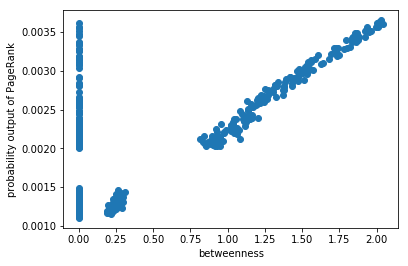

In [13]:
import matplotlib.pyplot as plt
plt.plot(y, x, "o")
plt.xlabel('betweenness')
plt.ylabel('probability output of PageRank')
plt.show()

# Everything in one shot

In [14]:
import matplotlib.pyplot as plt

def make_plots(g):
    def make_p_matrix(matrix):
        row_sums = matrix.sum(axis=1)
        return matrix / row_sums[:]
    
    def power_method2(H, v=None, alpha=0.85):
        if v is None:
             v = np.full(H.shape[1], 1/H.shape[1])
        d = ~(H.any(axis=1))
        w = np.full(H.shape[1], 1/H.shape[1])
        # start with pi = v
        pi = np.zeros(H.shape[0])
        pi_new = v
        cnt = 0
        while not np.allclose(pi_new, pi):
            pi = pi_new
            pi_new = alpha * pi * H + alpha * (pi*d) * w + (1-alpha) * v
            cnt += 1
        #print("Power method2 went through {} iteration".format(cnt))
        return pi_new
    
    m = make_p_matrix(np.matrix(networkx.convert_matrix.to_numpy_matrix(g), dtype=np.float64))
    c = power_method2(m)
    #brandes = Brandes(g)
    brandes = nx.betweenness_centrality(g)
    x = []
    y = []
    n = len(g)
    for i in range(n):
        x.append(c.item(i))  # PageRank Probability
    for node in g:
        y.append(brandes[node]) # Betweenness
    plt.plot(y, x, "o")
    plt.xlabel('betweenness')
    plt.ylabel('probability output of PageRank')
    plt.show()
    
    
    
    

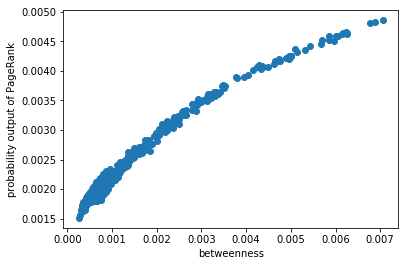

In [15]:
n = 400
g = networkx.barabasi_albert_graph(n, 100, seed=10)
make_plots(g)

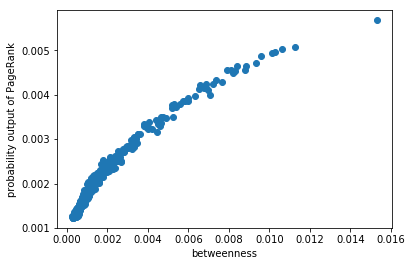

In [16]:
n = 500
g = networkx.barabasi_albert_graph(n, n//10, seed=10)
make_plots(g)

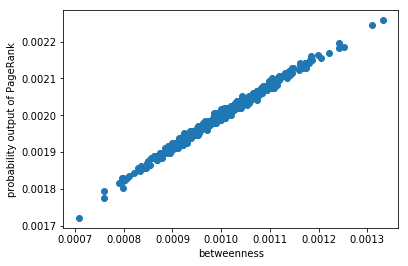

In [17]:
g = networkx.erdos_renyi_graph(500, p=0.5, seed=10)
make_plots(g)

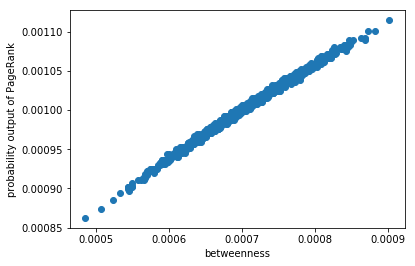

In [18]:
g = networkx.erdos_renyi_graph(1000, p=0.3, seed=10)
make_plots(g)

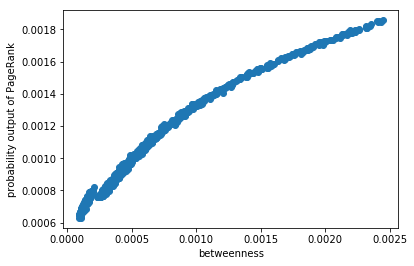

In [19]:
g = networkx.barabasi_albert_graph(1000, 300, seed=10)
make_plots(g)

In [31]:
def make_graph_from_dataset(filepath):
    with open(filepath) as f:
        a = f.readlines()
        edges = []
        for line in a:
            if line.startswith("#"):
                continue
            else:
                a,b = line.strip().split()
                edges.append((a,b))
    G = nx.Graph()
    G.add_edges_from(edges)
    return G
                
            

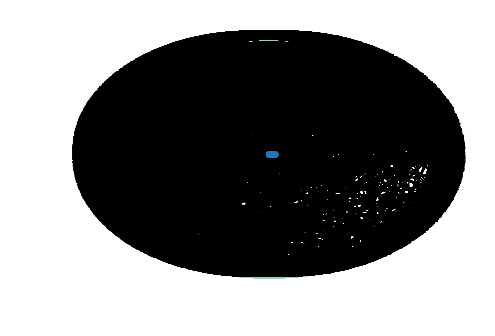

In [32]:
g = make_graph_from_dataset('data/CA-GrQc.txt')
len(g)
make_plots(g)

4592


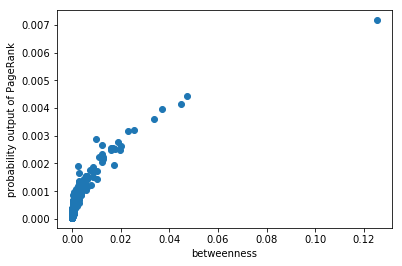

In [33]:
g = make_graph_from_dataset('data/links.tsv')
print(len(g))
make_plots(g)